In [1]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AfJohXn8eU6R4aBm3LakcbgdkVdvewfDSTOTo37AowLMOsXvCAbG7Nmhf7Y



Successfully saved authorization token.


In [19]:
import geemap.foliumap as geemap
import numpy as np
import osmnx as ox
import json
import math
import matplotlib.pyplot as plt

In [17]:
# Bounding box of Hong Kong
xmin = 113.8 - 0.02
ymin = 22.1
xmax = 114.5 - 0.02
ymax = 22.6

# Adjust the bbox to fit lego plates of 32 x 32 pixels
width_in_degrees = xmax - xmin
height_in_degrees = ymax - ymin
width_in_degrees_n = width_in_degrees * 0.9696969696969697 * 1.0078740157480315
height_in_degrees_n = height_in_degrees * 1.0212765957446808 

xmid = xmin + (width_in_degrees / 2)
ymid = ymin + (height_in_degrees / 2)
xmin_n = xmid - width_in_degrees_n / 2
xmax_n = xmid + width_in_degrees_n / 2
ymin_n = ymid - height_in_degrees_n / 2
ymax_n = ymid + height_in_degrees_n / 2

# make bounding box for Hong Kong
hk_bbox = ee.Geometry.Rectangle([xmin_n, ymin_n, xmax_n, ymax_n])

In [18]:
# get map projection from bbox and bedrock data
bedrock = ee.Image('projects/tanyatsui/assets/seabed_grid').clip(hk_bbox)
bedrock = bedrock.reproject(crs=bedrock.projection(), scale=600)
map_projection = bedrock.projection() 
map_crs = map_projection.getInfo()['crs']
map_transform = map_projection.getInfo()['transform']

# border (land + sea border)
border = ox.geocode_to_gdf("Hong Kong, China")
border_geojson = json.loads(border.to_json())
border = ee.Geometry.MultiPolygon(border_geojson['features'][0]['geometry']['coordinates'])
mask_border = ee.Image().byte().paint(border, 1)
mask_border = mask_border.reproject(crs=map_crs, crsTransform=map_transform)

# sea elevation 
mask_sea = bedrock.lte(0)
sea = bedrock.mask(mask_sea)
sea_threshold = -10
sea_elevation = sea.lte(sea_threshold).multiply(-2)
sea_elevation = sea_elevation.add(sea.gt(sea_threshold).multiply(-1))

# land elevation 
mask_land = bedrock.gt(0)
mask_combined = mask_land.And(mask_border)
land = bedrock.mask(mask_land)
hk = bedrock.mask(mask_combined)
hk_elevation = hk.lte(200).multiply(1)
hk_elevation = hk_elevation.add(hk.gt(200).And(hk.lte(400)).multiply(2))
hk_elevation = hk_elevation.add(hk.gt(400).And(hk.lte(600)).multiply(3))
hk_elevation = hk_elevation.add(hk.gt(600).multiply(4))

# built area
land_cover = ee.Image("MODIS/051/MCD12Q1/2001_01_01").select('Land_Cover_Type_1').clip(hk_bbox)
built = land_cover.eq(13)  # "Urban and Built-Up" class
built = built.reproject(crs=map_crs, crsTransform=map_transform)
mask_combined = mask_combined.And(built)
built = built.mask(mask_combined)

# calculate width and height of lego map
width = bedrock.getInfo()['bands'][0]['dimensions'][0]
height = bedrock.getInfo()['bands'][0]['dimensions'][1]
lego_pixel_size = 8 # mm 
message = f'''map will be {width*lego_pixel_size/10} cm by {height*lego_pixel_size/10}cm, 
and {width/32} by {height/32} lego plates'''
print(message)

map will be 102.4 cm by 77.6cm, 
and 4.0 by 3.03125 lego plates


In [11]:
# layer 1 - deep sea (lego 32 x 32 base places)
layer1_deepSea = sea_elevation.mask(sea_elevation.lte(10)).multiply(1) 

# make layer 2 - shallow sea + land
layer2_shallowSea = sea_elevation.mask(sea_elevation.gte(-1)).multiply(1) 
layer2_land = land.mask(land.gt(0)).multiply(2)

# layer 3 - land 
layer3_hk_1 = hk_elevation.mask(hk_elevation.gte(1)).multiply(1)
layer3_hk_2 = hk_elevation.mask(hk_elevation.gte(2)).multiply(2)
layer3_hk_3 = hk_elevation.mask(hk_elevation.gte(3)).multiply(3)
layer3_hk_4 = hk_elevation.mask(hk_elevation.gte(4)).multiply(4)

# layer 4 - built
layer4_built = built

In [12]:
m = geemap.Map(center=[22.399350718980347, 114.1028317524379], zoom=10)
m.addLayer(layer1_deepSea, {'palette': ['#243757']}, 'deep sea')
m.addLayer(layer2_shallowSea, {'palette': ['#0057A6']}, 'shallow sea')
m.addLayer(layer2_land, {'palette': ['#9C9C9C']}, 'land')
m.addLayer(layer3_hk_1, {'palette': ['#00923D']}, 'hk_elevation_1')
m.addLayer(layer3_hk_2, {'palette': ['#10CB31']}, 'hk_elevation_2')
m.addLayer(layer3_hk_3, {'palette': ['#C4E000']}, 'hk_elevation_3')
m.addLayer(layer3_hk_4, {'palette': ['#FFE001']}, 'hk_elevation_4')
m.addLayer(built, {'palette': ['#FF7E14']}, 'built')
m

In [13]:
%%time

def get_array(eeImage, bandName):
    data = eeImage.sampleRectangle(region=hk_bbox, defaultValue=0).get(bandName).getInfo()
    return np.array(data)

layers_dict = {
    'layer2_shallowSea': [layer2_shallowSea, 'b1'], 'layer2_land': [layer2_land, 'b1'], 
    'layer3_hk_1': [layer3_hk_1, 'b1'], 'layer3_hk_2': [layer3_hk_2, 'b1'], 
    'layer3_hk_3': [layer3_hk_3, 'b1'], 'layer3_hk_4': [layer3_hk_4, 'b1'], 
    'layer4_built': [built, 'Land_Cover_Type_1']
}

arrays_dict = {}
for name, eeImage_list in layers_dict.items(): 
    array = get_array(eeImage_list[0], eeImage_list[1])
    arrays_dict[name] = array
    np.save(f'data/{name}.npy', array)

CPU times: total: 8.97 s
Wall time: 15.9 s


layer2_shallowSea


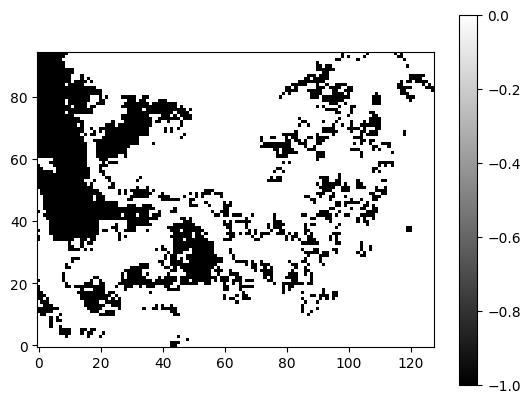

layer2_land


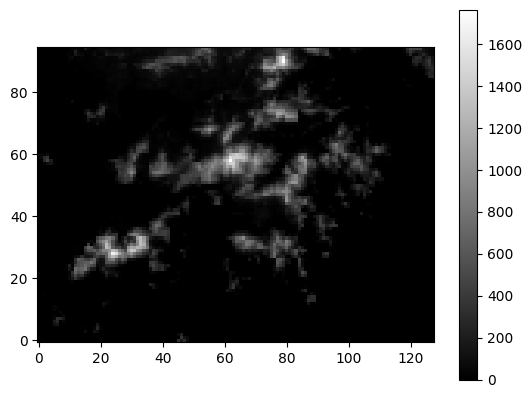

layer3_hk_1


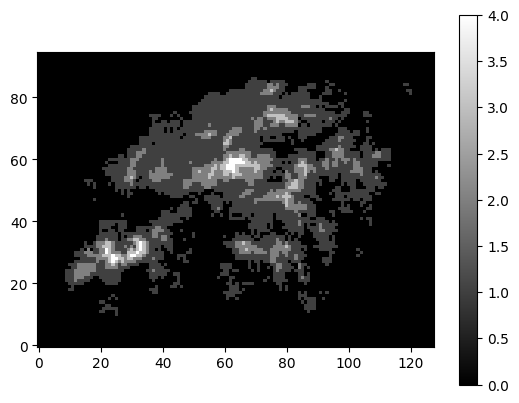

layer3_hk_2


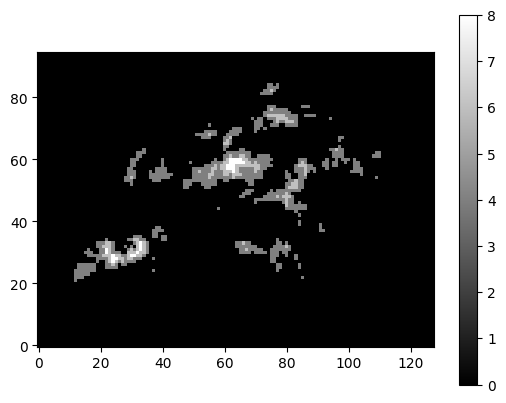

layer3_hk_3


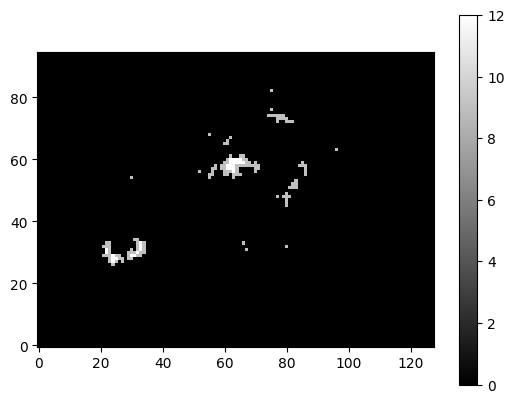

layer3_hk_4


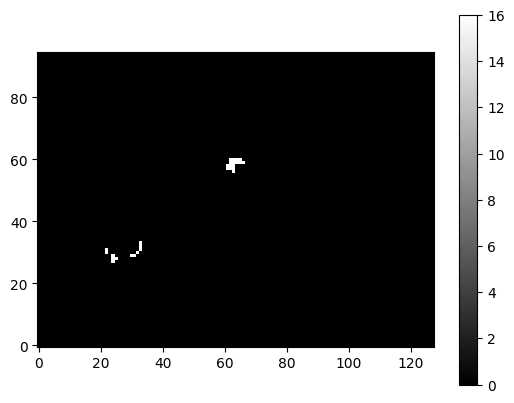

built


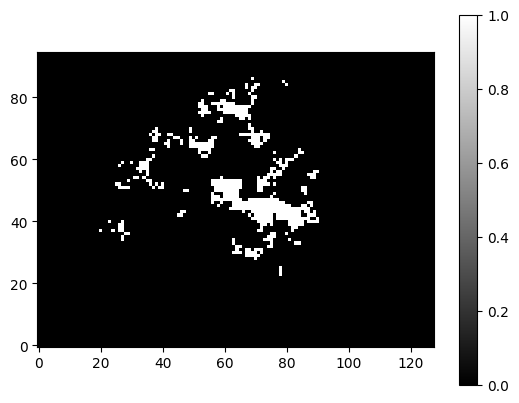

In [91]:
for name, array in arrays_dict.items(): 
    print(name)
    plt.imshow(array, cmap='gray', origin='lower')  # 'cmap' specifies the color map; 'gray' is just an example
    plt.colorbar()  # Adds a colorbar to indicate values
    plt.show()

In [138]:
pixel_width = 500 # 'scale' param in ee.Image.reproject()
legoPlate_size = pixel_width * 32 # 32 pixels, each 500m 

xmin = 113.8
ymin = 22.1
xmax = 114.5
ymax = 22.6

# extract xmin, ymin, xmax, ymax in meters - EPSG:32649
bottomLeft_coord = ee.Geometry.Point([xmin, ymin], 'EPSG:4326').transform('EPSG:32649', maxError=1)
topRight_coord = ee.Geometry.Point([xmax, ymax], 'EPSG:4326').transform('EPSG:32649', maxError=1)
xmin, ymin = bottomLeft_coord.getInfo()['coordinates']
xmax, ymax = topRight_coord.getInfo()['coordinates']

# adjust bbox to fit lego plates of 32 x 32 pixels of 500 m each 
width = xmax - xmin
height = ymax - ymin
width_n = math.ceil(width/legoPlate_size) * legoPlate_size
height_n = math.ceil(height/legoPlate_size) * legoPlate_size

xmid, ymid = xmin + width/2, ymin + height/2
xmin_n, ymin_n = xmid - width_n/2, ymid - height_n/2
xmax_n, ymax_n = xmid + width_n/2, ymid + height_n/2

# convert bbox coords back into degrees - EPSG:4326
bottomLeft_coord_n = ee.Geometry.Point([xmin_n, ymin_n], 'EPSG:32649').transform('EPSG:4326', maxError=1)
topRight_coord_n = ee.Geometry.Point([xmax_n, ymax_n], 'EPSG:32649').transform('EPSG:4326', maxError=1)
xmin, ymin = bottomLeft_coord_n.getInfo()['coordinates']
xmax, ymax = topRight_coord_n.getInfo()['coordinates']

# Define a new projection with your desired resolution and CRS
origin = [xmin, ymax] # Top-left corner of your bounding box
desired_projection = ee.Projection('EPSG:4326').atScale(pixel_width)
# adjusted_projection = desired_projection.translate(xmin - desired_projection.getInfo()['transform'][2], ymax - desired_projection.getInfo()['transform'][5])
# adjusted_projection = adjusted_projection.transform('EPSG:4326')

# define bbox, map
hk_bbox = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])
bedrock = ee.Image('projects/tanyatsui/assets/seabed_grid').clip(hk_bbox)
# bedrock = bedrock.reproject(crs=bedrock.projection(), scale=pixel_width)
bedrock = bedrock.reproject(desired_projection)
width = bedrock.getInfo()['bands'][0]['dimensions'][0]
height = bedrock.getInfo()['bands'][0]['dimensions'][1]
# width = 178
# height = 127 
bedrock

In [118]:
pixel_width = 500 # 'scale' param in ee.Image.reproject()
legoPlate_size = pixel_width * 32 # 32 pixels, each 500m 

xmin = 113.8
ymin = 22.1
xmax = 114.5
ymax = 22.6
print(xmax-xmin, ymax-ymin)

# extract xmin, ymin, xmax, ymax in meters - EPSG:32649
bottomLeft_coord = ee.Geometry.Point([xmin, ymin], 'EPSG:4326').transform('EPSG:32649', maxError=1)
topRight_coord = ee.Geometry.Point([xmax, ymax], 'EPSG:4326').transform('EPSG:32649', maxError=1)
xmin, ymin = bottomLeft_coord.getInfo()['coordinates'][0], bottomLeft_coord.getInfo()['coordinates'][1]
xmax, ymax = topRight_coord.getInfo()['coordinates'][0], topRight_coord.getInfo()['coordinates'][1]

# adjust bbox to fit lego plates of 32 x 32 pixels of 500 m each 
width = xmax - xmin
height = ymax - ymin
width_n = math.ceil(width/legoPlate_size)*legoPlate_size
height_n = math.ceil(height/legoPlate_size)*legoPlate_size
xmid, ymid = xmin+(xmax-xmin)/2, ymin+(ymax-ymin)/2
xmin_n, ymin_n = xmid - width_n/2 , ymid - height_n/2
xmax_n, ymax_n = xmid + width_n/2 , ymid + height_n/2

print(width_n/width*100, height_n/height*100)
print(xmin, ymin, xmax, ymax)
print(xmid, ymid)
print(xmin_n, ymin_n, xmax_n, ymax_n)
print(width_n, height_n)
print(f'width = {width_n/500/32} plates | height = {height_n/500/32} plates')
print(xmax_n - xmin_n, ymax_n - ymin_n)

# convert bbox coords back into degrees - EPSG:4326
bottomLeft_coord_n = ee.Geometry.Point([xmin_n, ymin_n], 'EPSG:32649').transform('EPSG:4326', maxError=1)
topRight_coord_n = ee.Geometry.Point([xmax_n, ymax_n], 'EPSG:32649').transform('EPSG:4326', maxError=1)
xmin, ymin = bottomLeft_coord_n.getInfo()['coordinates'][0], bottomLeft_coord_n.getInfo()['coordinates'][1]
xmax, ymax = topRight_coord_n.getInfo()['coordinates'][0], topRight_coord_n.getInfo()['coordinates'][1]
print(xmin, ymin, xmax, ymax)
print(xmax-xmin, ymax-ymin)

0.7000000000000028 0.5
112.68557005215145 112.44643731973301
788898.3027491474 2446552.889867954 859892.3084261614 2503468.8771820036
824395.3055876545 2475010.8835249785
784395.3055876545 2443010.8835249785 864395.3055876545 2507010.8835249785
80000 64000
width = 5.0 plates | height = 4.0 plates
80000.0 64000.0
113.75577515974584 22.06877890799013 114.54454756067797 22.630976259670387
0.7887724009321317 0.5621973516802576


In [17]:
from math import cos, radians, ceil

# Given coordinates
xmin = 113.8
ymin = 22.1
xmax = 114.5
ymax = 22.6

# Convert width and height from degrees to meters
average_latitude = (ymin + ymax) / 2
degree_of_longitude_in_meters = 111320 * cos(radians(average_latitude))
width_in_meters = (xmax - xmin) * degree_of_longitude_in_meters
height_in_meters = (ymax - ymin) * 111320  # Degree of latitude is roughly constant

# Adjust the dimensions to be divisible by 32
adjusted_width_in_meters = ceil(width_in_meters / 32) * 32
adjusted_height_in_meters = ceil(height_in_meters / 32) * 32

# Convert back to degrees
adjusted_width_in_degrees = adjusted_width_in_meters / degree_of_longitude_in_meters
adjusted_height_in_degrees = adjusted_height_in_meters / 111320

# Compute the adjusted xmax and ymax values
adjusted_xmax = xmin + adjusted_width_in_degrees
adjusted_ymax = ymin + adjusted_height_in_degrees

print(adjusted_xmax, adjusted_ymax)

114.5002504816287 22.600179662235


In [124]:
# define bbox
xmin = 113.8
ymin = 22.1
xmax = 114.5
ymax = 22.6
hk_bbox = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])
map_width_degrees = round(xmax - xmin,1)
map_height_degrees = round(ymax - ymin,1)

# Load the image and clip it
bedrock = ee.Image('projects/tanyatsui/assets/seabed_grid').clip(hk_bbox)
# bedrock = bedrock.reproject(crs='EPSG:32649', scale=500)
bedrock = bedrock.reproject(crs=bedrock.projection(), scale=500)

npixels_width = bedrock.getInfo()['bands'][0]['dimensions'][0]
npixels_height = bedrock.getInfo()['bands'][0]['dimensions'][1]

In [121]:
npixels_width_new = ceil(npixels_width/32)*32
npixels_height_new = ceil(npixels_height/32)*32

pixel_width_degrees = map_width_degrees / npixels_width
pixel_height_degrees = map_height_degrees / npixels_height

map_width_degrees_new = pixel_width_degrees * npixels_width_new
map_height_degrees_new = pixel_height_degrees * npixels_height_new

xmax_new = xmax + map_width_degrees_new
ymax_new = ymax + map_height_degrees_new
hk_bbox = ee.Geometry.Rectangle([xmin, ymin, xmax_new, ymax_new])
bedrock = ee.Image('projects/tanyatsui/assets/seabed_grid').clip(hk_bbox)
bedrock = bedrock.reproject(crs=bedrock.projection(), scale=500)

In [127]:
npixels_width_new

160

In [122]:
bedrock

In [195]:
# elevation data 
srtm = ee.Image('USGS/SRTMGL1_003')
hk_elevation = srtm.clip(hk_bbox)
hk_elevation = hk_elevation.reproject(crs='EPSG:3857', crsTransform=modis_transform)
combined_mask = political_boundary.And(land)
hk_elevation = hk_elevation.mask(combined_mask)

classified_image = hk_elevation.lte(250).multiply(1)
classified_image = classified_image.add(hk_elevation.gt(250).And(hk_elevation.lte(500)).multiply(2))
classified_image = classified_image.add(hk_elevation.gt(500).And(hk_elevation.lte(750)).multiply(3))
classified_image = classified_image.add(hk_elevation.gt(750).multiply(4))

In [202]:
hk_bbox = ee.Geometry.Rectangle([113.8, 22.1, 114.5, 22.6])

# land boundary
land_cover = ee.Image("MODIS/051/MCD12Q1/2001_01_01").select('Land_Cover_Type_1').clip(hk_bbox)
modis_projection = land_cover.projection()
modis_crs = original_projection.getInfo()['crs']
modis_transform = original_projection.getInfo()['transform']
land_cover = land_cover.reproject(crs='EPSG:3857', crsTransform=modis_transform)
mask = land_cover.neq(0)
land = land_cover.mask(mask)
land = land.neq(0)

# political boundary
hk_boundary = ox.geocode_to_gdf("Hong Kong, China")
hk_geojson = json.loads(hk_boundary.to_json())
hk_boundary = ee.Geometry.MultiPolygon(hk_geojson['features'][0]['geometry']['coordinates'])
hk_mask = ee.Image().byte().paint(hk_boundary, 1)
hk_mask = hk_mask.reproject(crs='EPSG:3857', crsTransform=modis_transform)
political_boundary = land_cover.multiply(hk_mask)

# elevation data 
srtm = ee.Image('USGS/SRTMGL1_003')
hk_elevation = srtm.clip(hk_bbox)
hk_elevation = hk_elevation.reproject(crs='EPSG:3857', crsTransform=modis_transform)
combined_mask = political_boundary.And(land)
hk_elevation = hk_elevation.mask(combined_mask)

# bedrock elevation data (to see elevation under the sea)
gebco = ee.Image('NOAA/NGDC/ETOPO1').select('bedrock') 
hk_seaFloor = gebco.clip(hk_bbox)
hk_seaFloor = hk_seaFloor.reproject(crs='EPSG:3857', crsTransform=modis_transform)
array_data = hk_seaFloor.sampleRectangle(region=hk_bbox, defaultValue=0).get('bedrock').getInfo()
hk_seaFloor_array = np.array(array_data)

# built area
built = land_cover.eq(13)  # "Urban and Built-Up" class
combined_mask = combined_mask.And(built)
built = built.reproject(crs='EPSG:3857', crsTransform=modis_transform)
built = built.mask(combined_mask)